# Rice Kernel Image Classification 

  * This is the code to "Build Rice Kernel Image Classification model in PyTorch"
  * This classification can provide insights into the quality of rice, which is important for trading and pricing in the rice industry
  * Please do not use this code for commercial purposes unless approved by the author


### Two Options
    1. make the model from scratch
       - define CNN from scratch
    2. use existing model 
       - Use ResNet- 18 model

> # 1. Make the neural network from scratch

#### 1: Set up the enivronment

In [246]:
import matplotlib.pyplot as plt # for plotting
import numpy as np 
import pandas as pd

import torch # PyTorch package
import torchvision # load datasets
import torchvision.transforms as transforms # transform data
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer

from sklearn.preprocessing import LabelEncoder

import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [247]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use the GPU
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")  # Use the CPU
    print("GPU is not available. Using CPU.")


Using GPU: NVIDIA GeForce RTX 4060 Laptop GPU


### 2: Import the data

In [285]:
data_dir = r"C:\Users\User\Documents\New folder\Github\Data Resources\data_test"
# Initialize lists to store image data and corresponding class labels
images = []
labels = []

# Loop through subfolders (each subfolder represents a class)
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    
    # Check if the item in the directory is a folder (class subfolder)
    if os.path.isdir(class_dir):
        # Iterate through image files in the subfolder
        for image_filename in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_filename)
            
            # Load the image using Pillow (PIL)
            image = Image.open(image_path)
            
            # Resize the image to a consistent size (36x35 pixels)
            image = image.resize((35,36))
            
            # Convert the image to a NumPy array
            image_array = np.array(image)
            
            # Append the image data and corresponding class label
            images.append(image_array)
            labels.append(class_name)


Shape of images array: (1632, 36, 35, 3)
(36, 35, 3)


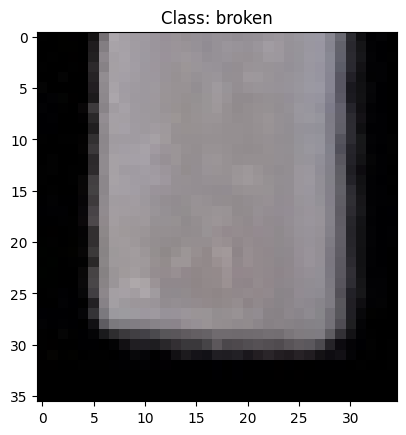

In [286]:
# Convert the lists to NumPy arrays
images = np.array(images)
labels_cat = np.array(labels)

# Check the shape of the loaded images array (num_images, height, width, num_channels)
print(f"Shape of images array: {images.shape}")

# Display the first image from the loaded dataset
print(images[0].shape)
plt.imshow(images[0])
plt.title(f"Class: {labels_cat[0]}")
plt.axis('on')
plt.show()

In [287]:
min_pixel_value = np.min(images)
max_pixel_value = np.max(images)

print(f"Minimum Pixel Value: {min_pixel_value}")
print(f"Maximum Pixel Value: {max_pixel_value}")

Minimum Pixel Value: 0
Maximum Pixel Value: 255


In [288]:
# Get unique values
classes = np.unique(labels_cat)

# Print the unique values
print(classes)

['broken' 'butt' 'full_10' 'full_8' 'full_9' 'full_9.5']


In [289]:
label_encoder = LabelEncoder()
label_encoder.fit(labels_cat)
# Transform the class labels into numerical labels
encoded_labels = label_encoder.transform(labels_cat)

# Print the original class labels and their corresponding numerical labels
#for original_label, encoded_label in zip(labels, encoded_labels):
#    print(f"Original Label: {original_label}, Encoded Label: {encoded_label}")

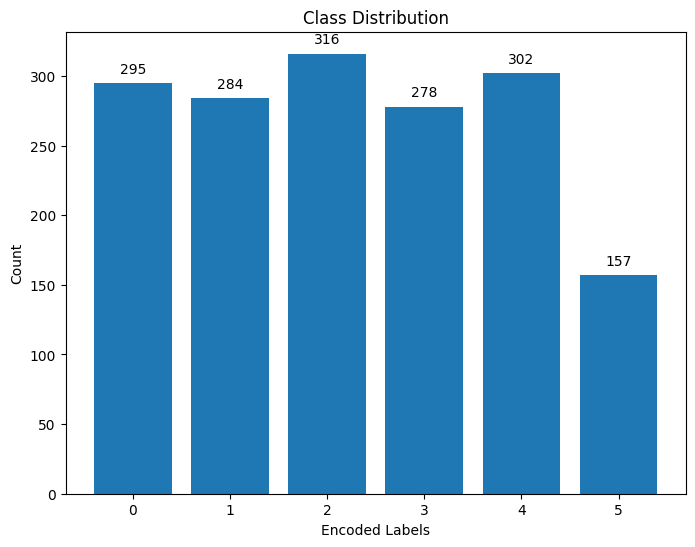

In [290]:
# Calculate the unique labels and their frequencies
unique_labels, label_counts = np.unique(encoded_labels, return_counts=True)

# Create a bar plot to visualize class distribution
plt.figure(figsize=(8, 6))
bars = plt.bar(unique_labels, label_counts, tick_label=unique_labels)

# Annotate the values on each bar
for bar, count in zip(bars, label_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, str(count), ha='center', va='bottom')

# Set plot labels and title
plt.xlabel('Encoded Labels')
plt.ylabel('Count')
plt.title('Class Distribution')

# Show the plot
plt.show()


### 3: Data Preprocessing

In [291]:
# Convert images and labels to PyTorch tensors
images_tr = torch.from_numpy(images).float()
labels = torch.from_numpy(encoded_labels)

In [292]:
print(images_tr.shape)
print(labels.shape)

torch.Size([1632, 36, 35, 3])
torch.Size([1632])


In [293]:
#print(images_tr[0][0]) #Red Channel
#print(images_tr[0][1]) #Green Channel
#print(images_tr[0][2]) #Blue Channel

In [294]:
# Normalize the image data to the range [-1, 1]
#the original pixel values were in the range [0, 255] #[0, 1] to [0, 2] to [-1, 1]
images_normalized = (images_tr / 255.0) * 2.0 - 1.0

In [295]:
# Reshape the images to [1632, 3, 35, 36]
images_reshaped = images_normalized.permute(0, 3, 1, 2)
print(images_reshaped.shape)

torch.Size([1632, 3, 36, 35])


In [296]:
# Split the dataset into training and test sets
train_images, test_images, train_labels, test_labels = train_test_split(
    images_reshaped, labels, test_size=0.2, random_state=42)

In [297]:
# Create DataLoader objects for training and test sets
batch_size = 25 
train_dataset = TensorDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [298]:
test_dataset = TensorDataset(test_images, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [299]:
print(f"Shape of train_loader dataset: {train_loader.dataset.tensors[0].shape}")
print(f"Shape of test_loader dataset: {test_loader.dataset.tensors[0].shape}")

# Check the number of samples in the training and test sets
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Shape of train_loader dataset: torch.Size([1305, 3, 36, 35])
Shape of test_loader dataset: torch.Size([327, 3, 36, 35])
Number of training samples: 1305
Number of test samples: 327


### 4: Create the model

In [304]:
class Net(nn.Module):
    def __init__(self):
        ''' initialize the network '''
        super(Net, self).__init__()
        
        # 3 input image channel, 6 output channels, # 5x5 square convolution kernel	    
        self.conv1 = nn.Conv2d(3, 6, 5)
        # Max pooling over a (2, 2) window
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 6)    
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 5x5 from image dimension # each feature map is 5x5 pixels in size, and there are 16 such feature maps
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 6)
# (36 x 35)                 # (224 x 224)
#torch.Size([25, 6, 16, 15]) torch.Size([25, 6, 110, 110])  
#torch.Size([25, 16, 5, 5])  torch.Size([25, 16, 52, 52])   
#(16 * 5 * 5, 120)           (16 * 52 * 52, 120)
    def forward(self, x):
        ''' the forward propagation algorithm '''
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.size()) #torch.Size([4, 6, 110, 110]) #[4, 6, 14, 14]
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.size()) #  #[4, 16, 5, 5]
        x = x.view(-1, 16 * 5 * 5)
        #print(x.size())
        x = F.relu(self.fc1(x))   
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(6, 6), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
)


### 5: Define a Loss function and optimizer

In [305]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 6: Train the network

In [306]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

In [307]:
start.record()
loss_values = []
train_accuracy_1 = []
#1train_accuracy_2 = []

for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    running_correct = 0.0
    predicted_correctly_on_epoch = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels = labels.to(torch.int64)
        total += labels.size(0)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        _,predicted = torch.max(outputs.data,1)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

       
        running_correct += (labels == predicted).sum().item()

        epoch_loss = running_loss/ len(train_loader)
        epoch_acc = 100.00 * running_correct / total

        loss_values.append(epoch_loss)
    
    if (epoch + 1) in [25, 50, 75, 100]:
         print('[Epoch %d] '  % (epoch + 1))
         print(" - Training Dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f" 
              %(running_correct, total, epoch_acc, epoch_loss)) 
train_accuracy_1.append(epoch_acc)
#train_accuracy_2.append(epoch_acc)
# whatever you are timing goes here
end.record()

[Epoch 25] 
 - Training Dataset. Got 924 out of 1305 images correctly (70.805%). Epoch loss: 0.729
[Epoch 50] 
 - Training Dataset. Got 1052 out of 1305 images correctly (80.613%). Epoch loss: 0.441
[Epoch 75] 
 - Training Dataset. Got 1080 out of 1305 images correctly (82.759%). Epoch loss: 0.370
[Epoch 100] 
 - Training Dataset. Got 1116 out of 1305 images correctly (85.517%). Epoch loss: 0.308


In [308]:
# Waits for everything to finish running
torch.cuda.synchronize()
finished_training_time1 = start.elapsed_time(end)  
print('Finished Training')
print(finished_training_time1)  # milliseconds

Finished Training
24286.955078125


In [270]:
# Waits for everything to finish running
torch.cuda.synchronize()
finished_training_time2 = start.elapsed_time(end)  
print('Finished Training')
print(finished_training_time2)  # milliseconds

Finished Training
629385.6875


### 7: Test the network on test data

torch.Size([25, 3, 224, 224])


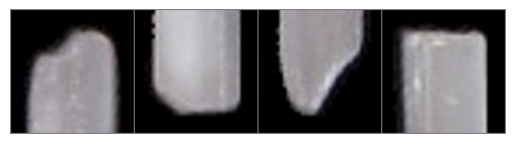

Labels: full_9 broken full_10 broken


In [94]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow(img):
    ''' Function to show images '''
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()  # Convert to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # Turn off axis labels and ticks
    plt.show()

# Get a batch of training images and labels
dataiter = iter(train_loader)
images, labels = dataiter.__next__()    #  to get the next batch

# Print the shape of the batch of images
print(images.shape)

# Display the first 4 images from the batch horizontally along with their class labels
num_images_to_show = 4
combined_image = torchvision.utils.make_grid(images[:num_images_to_show], nrow=num_images_to_show)  # Combine images horizontally
imshow(combined_image)

# Print the class labels for each image in a single line
class_labels = ' '.join([classes[labels[i].item()] for i in range(num_images_to_show)])
print('Labels:', class_labels)


In [271]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

In [309]:
start.record()

correct = 0
total = 0
test_accuracy_1 = []
#test_accuracy_2 = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
    
        outputs = net(images)
        #print(outputs.data)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = correct / total
    test_accuracy_1.append(accuracy)
    #test_accuracy_2.append(accuracy)

print('Accuracy of the network on the 327 test images: %d %%' % (100 * correct / total))
print('Test Accuracy :',{accuracy})

end.record()

Accuracy of the network on the 327 test images: 84 %
Test Accuracy : {0.8440366972477065}


In [310]:
# Waits for everything to finish running
torch.cuda.synchronize()
finished_testing_time1 = start.elapsed_time(end)
print('Finished Testing')
print(finished_testing_time1)

Finished Testing
31.010080337524414


 ### Display the 'CNN Training Results' table 

In [314]:
data = {
    'Model': ['CNN', 'CNN'],
    'Batch Size': [24, 24],
    'Image Size': ['36x35', '224x224'],
    'Total Epoch': [100, 100],
    'Training Accuracy': [0.8551, 0.7767],
    'Testing Accuracy': [0.8440, 0.7865],
    'Finished Training Time (milliseconds)': [629385.6875,629385.6875],
    'Finished Testing Time (milliseconds)':[31.010, 659.151184]
}

df_CNN = pd.DataFrame(data)

# Display the DataFrame
df_CNN.head()


,Model,Batch Size,Image Size,Total Epoch,Training Accuracy,Testing Accuracy,Finished Training Time (milliseconds),Finished Testing Time (milliseconds)
0,CNN,24,36x35,100,0.8551,0.8440,629385.6875,31.010000
1,CNN,24,224x224,100,0.7767,0.7865,629385.6875,659.151184


> # 2. Use existing model 

In [315]:
import os
from PIL import Image
import torch # PyTorch package
import torchvision # load datasets
import torchvision.transforms as transforms # transform data
from torchvision.datasets import ImageFolder
import torchvision.models as models 
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split,Dataset
from sklearn.model_selection import train_test_split




In [316]:
data_dir = r"C:\Users\User\Documents\New folder\Github\Data Resources\data_test"
os.listdir(data_dir)

['broken', 'butt', 'full_10', 'full_8', 'full_9', 'full_9.5']

### 1. Calculate mean and std 

In [317]:
data_transforms = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])  

dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=data_transforms)

data_loader = torch.utils.data.DataLoader(dataset=dataset,batch_size=12,shuffle=False)

In [318]:
def get_mean_and_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images,_ in loader:
        image_count_in_a_batch = images.size(0) #extract images and ignore lables
        #print(images.shape) #torch.Size([12, 3, 224, 224])
        #reshape a 2D format with dimensions [batch_size, num_channels, num_pixels], where num_pixels = height * width.
        images = images.view(image_count_in_a_batch,images.size(1),-1)
        #print(images.shape) #torch.Size([12, 3, 50176])
        mean += images.mean(2).sum(0) #calculate the mean and standard deviation along the -2 dimension (columns) for each image
        std += images.std(2).sum(0) #summed across all images
        total_images_count += image_count_in_a_batch #keep track of the total number of images processed across all batches
    
    #to compute the mean and standard deviation of pixel values across the entire dataset
    mean /= total_images_count 
    std /= total_images_count

    return mean,std
get_mean_and_std(data_loader)

(tensor([0.3160, 0.3074, 0.3189]), tensor([0.3004, 0.2936, 0.3024]))

### 2. Image Dataset Prepration

In [319]:
# Define the batch size for your DataLoader
batch_size = 32

In [320]:
mean= [0.3160, 0.3074, 0.3189]
std = [0.3004, 0.2936, 0.3024]

train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))]) 

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))])

In [321]:
# Create ImageFolder datasets for training and testing separately
training = ImageFolder(root=data_dir, transform=train_transforms)
testing = ImageFolder(root=data_dir, transform=test_transforms) 

In [322]:
# Check the number of samples in the training and test sets
print(f"Number of training samples: {len(training)}")
print(f"Number of test samples: {len(testing)}")

Number of training samples: 1632
Number of test samples: 1632


In [324]:
# Split the datasets into training and testing sets 
train_size = int(0.8 * len(testing)) #1305
test_size = len(testing) - train_size #327

test_dataset, val_dataset = torch.utils.data.random_split(testing, [train_size, test_size])
#print(len(test_dataset))
# Create DataLoader objects for training, validation, and testing
train_loader = DataLoader(training, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([5, 2, 3, 5, 5, 5])


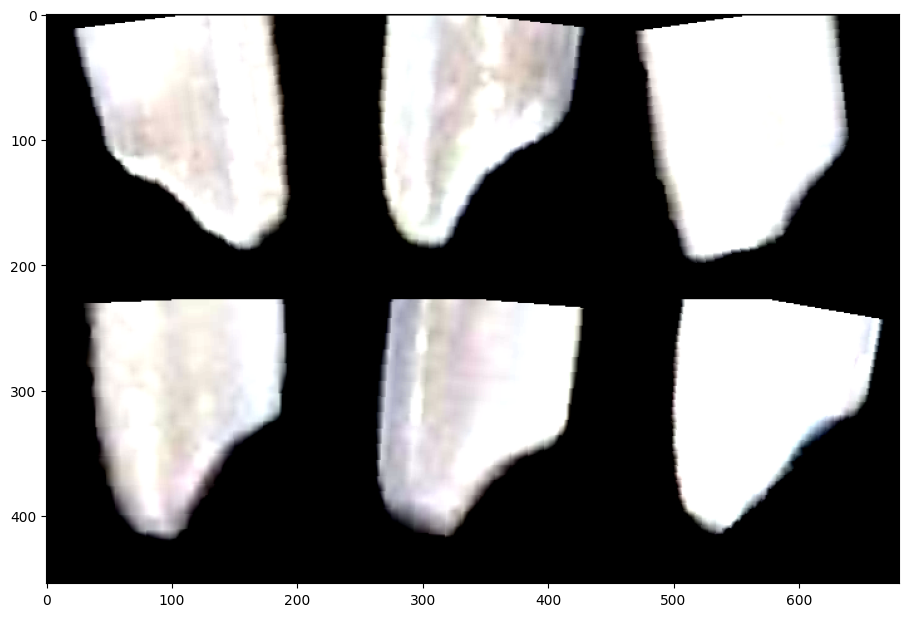

In [222]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset,batch_size=6,shuffle=True)
    batch = next(iter(loader))
    images,labels = batch

    grid = torchvision.utils.make_grid(images,nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid,(1,2,0)))
    print('labels: ',labels)

show_transformed_images(training)

### 3. Train and Evaluate the neural Netowrk
    Define 4 functions
   - set_device() : checks whether a CUDA-compatible GPU (parallel computing/ speed up training)
   - train_nn() : the main function to trian neural network
   - evaluate_model_on_test_set() : evaluation function 
   - save_checkpoint() : to save the trained model

In [325]:
def set_device():
    if torch.cuda.is_available():
        dev = "cuda:0"
    else:
        dev = "cpu"
    return torch.device(dev)

In [326]:
def train_nn(model, train_loader, test_loader, eve_model, criterion, optimizer,n_epochs,save_checkpoint):
    device = set_device()
    best_acc = 0
   
    
    for epoch in range(n_epochs):
        #print("Epoch number %d" % (epoch + 1))
        
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0
      
        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            optimizer.zero_grad()
            outputs = model(images)

            _,predicted = torch.max(outputs.data,1)
            loss = criterion(outputs,labels)

            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            running_correct += (labels == predicted).sum().item()

        epoch_loss = running_loss/ len(train_loader)
        epoch_acc = 100.00 * running_correct / total
        
        
        #print(" - Training Dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f" 
        #      %(running_correct, total, epoch_acc, epoch_loss))              
        if (epoch + 1) in [25, 50, 75, 100]:
               print('[Epoch %d] '  % (epoch + 1))
               print(" - Training Dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f" 
                                   %(running_correct, total, epoch_acc, epoch_loss)) 
       
        
        #test_dataset_acc = eve_model(model, test_loader)
        test_dataset_acc, predicted_correctly_on_epoch, total = eve_model(model, test_loader)
        if (epoch + 1) in [25, 50, 75, 100]:
              print('[Epoch %d] '  % (epoch + 1))
              print(" - Testing dataset. Got %d out of %d images correctly (%.3f%%)" % (predicted_correctly_on_epoch, total, test_dataset_acc))
            

        if(test_dataset_acc > best_acc):
            best_acc = test_dataset_acc
            save_checkpoint(model,epoch,optimizer,best_acc)
   
   

    print("Finished")
   
    return model
    

In [327]:
def evaluate_model_on_test_set(model,test_loader):
   
    model.eval()
    predicted_correctly_on_epoch = 0
    total = 0
    
    device = set_device()
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            outputs = model(images)

            _, predicted = torch.max(outputs.data,1)

            predicted_correctly_on_epoch += (predicted == labels).sum().item()

    epoch_acc = 100 * predicted_correctly_on_epoch / total
    #print("    - Testing dataset. Got %d out of %d images correctly (%.3f%%)" % (predicted_correctly_on_epoch, total, epoch_acc))
    
    
    return epoch_acc, predicted_correctly_on_epoch, total

In [328]:
def save_checkpoint(model, epoch, optimizer, best_acc):
    state = {
        'epoch' : epoch + 1,
        'model' : model.state_dict(),
        'best accuracy' : best_acc,
        'optimizer' :  optimizer.state_dict(),
        'comment' : "The best model!",
        
    }
    file_path = r"C:\Users\User\Documents\New folder\Github\computervision-tools\Pretrained_models_saved\model_best_checkpoint.pth.tar"
    torch.save(state,file_path)

### ResNet-18
    ImageNet Large Scale Visual Recognition Challenge (ILSVRC)
    
     Architecture: 18 layers (convolutional layers, batch normalization, ReLU activation functions, residual blocks)
     Preprocessing: input images size (224x224 pixels), input channels (RGB images) 
     PyTorch: pre-trained ResNet-18 models for transfer learning on ImageNet dataset(over 14 million images & 100 image categories)
    


In [329]:
resente_18_model = models.resnet18(weights=None)
num_ftrs = resente_18_model.fc.in_features
number_of_classes = 6
resente_18_model.fc = nn.Linear(num_ftrs,number_of_classes)
device = set_device()
resente_18_model = resente_18_model.to(device)
loss_fn = nn.CrossEntropyLoss()


optimizer = optim.SGD(resente_18_model.parameters(),lr=0.001,momentum=0.9,weight_decay=0.003)

In [330]:
train_nn(resente_18_model,train_loader,test_loader,evaluate_model_on_test_set,loss_fn, optimizer, 100,save_checkpoint)


[Epoch 25] 
 - Training Dataset. Got 1358 out of 1632 images correctly (83.211%). Epoch loss: 0.428
[Epoch 25] 
 - Testing dataset. Got 1064 out of 1305 images correctly (81.533%)
[Epoch 50] 
 - Training Dataset. Got 1394 out of 1632 images correctly (85.417%). Epoch loss: 0.340
[Epoch 50] 
 - Testing dataset. Got 1072 out of 1305 images correctly (82.146%)
[Epoch 75] 
 - Training Dataset. Got 1425 out of 1632 images correctly (87.316%). Epoch loss: 0.282
[Epoch 75] 
 - Testing dataset. Got 1163 out of 1305 images correctly (89.119%)
[Epoch 100] 
 - Training Dataset. Got 1470 out of 1632 images correctly (90.074%). Epoch loss: 0.221
[Epoch 100] 
 - Testing dataset. Got 1182 out of 1305 images correctly (90.575%)
Finished


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [90]:
# Define the file path to the saved checkpoint
checkpoint_file = r"C:\Users\User\Documents\New folder\Github\computervision-tools\Pretrained_models_saved\model_best_checkpoint.pth.tar"

# Load the checkpoint
checkpoint = torch.load(checkpoint_file)
print(checkpoint['epoch'])
print(checkpoint['comment'])
print(checkpoint['best accuracy'])

4
The best model!
77.98165137614679


#### Saved the model without any information

In [93]:
resente_18_model = models.resnet18()
num_ftrs = resente_18_model.fc.in_features
number_of_classes = 6
resente_18_model.fc = nn.Linear(num_ftrs,number_of_classes)
resente_18_model.load_state_dict(checkpoint['model'])
file_path = r"C:\Users\User\Documents\New folder\Github\computervision-tools\Pretrained_models_saved\best_model.pth"
torch.save(resente_18_model,file_path)

### 4. Load the model and Classify the random image

In [110]:
classes = ['broken', 'butt', 'full_10' ,'full_8' ,'full_9', 'full_9.5']

In [100]:
loaded_model = r"C:\Users\User\Documents\New folder\Github\computervision-tools\Pretrained_models_saved\best_model.pth"
# Load the model
model = torch.load(loaded_model)

In [111]:
mean= [0.3160, 0.3074, 0.3189]
std = [0.3004, 0.2936, 0.3024]

image_transforms = transforms.Compose([
    transforms.Resize((224,224)),    
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))]) 


In [112]:
def classify(model, image_transforms,image_path, classes):
    model = model.eval()
    image = Image.open(image_path)
    image = image_transforms(image).float()
    image = image.unsqueeze(0)

    output = model(image)
    _, predicted = torch.max(output.data,1)
    print(predicted.item())

    print(classes[predicted.item()])


In [113]:
img_path= r"c:\Users\User\Documents\New folder\Github\Data Resources\data_test\broken\k1_broken_50_13_2.32_58_25.jpg"
classify(model,image_transforms,img_path,classes)

0
broken


### Display the 'ResNet-18 Training Results' table 

In [332]:
import pandas as pd 
data = {
    'Model': ['ResNet-18', 'ResNet-18'],
    'Batch Size': [24, 24],
    'Image Size': ['224x224', '224x224'],
    'Total Epoch': [100, 100],
    'Learning Rate': [0.001,0.01],
    'Training Accuracy': [0.90074,0.89154],
    'Testing Accuracy': [0.90575, 0.9065]    
}

df_ResNet = pd.DataFrame(data)
df_ResNet.head()


,Model,Batch Size,Image Size,Total Epoch,Learning Rate,Training Accuracy,Testing Accuracy
0,ResNet-18,24,224x224,100,0.001,0.90074,0.90575
1,ResNet-18,24,224x224,100,0.010,0.89154,0.90650
